# Predicting Credit Card Default

### Data Set Information:

**This research aimed at the case of customers default payments in Taiwan**

### Features description:

- LIMIT_BAL: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- SEX: Gender (1 = male; 2 = female). 
- EDUCATION: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- MARRIAGE: Marital status (1 = married; 2 = single; 3 = others). 
- AGE: Age (year). 
- PAY_0 - PAY_6: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 0 = the repayment status in September, 2005; 1 = the repayment status in August, 2005; . . .; 6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- BILL_AMT1-BILL_AMT6: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
- PAY_AMT1-PAY_AMT6: Amount of previous payment (NT dollar).
- default payment next month: **positive class: default | negative class: pay**

In [1]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Data Preparation


In [32]:
default = pd.read_csv('credit_card_default.csv', delimiter=';')
default.rename(columns=lambda x: x.lower(), inplace=True)
# Dummy values
default['grad_school'] = (default['education'] == 1).astype('int')
default['university'] = (default['education'] == 2).astype('int')
default['high_school'] = (default['education'] == 3).astype('int')
default.drop('education', axis=1, inplace=True)

default['male'] = (default['sex'] == 1).astype('int')
default.drop('sex', axis=1, inplace=True)

default['married'] = (default['marriage'] == 1).astype('int')
default.drop('marriage', axis=1, inplace=True)
pay_features = ['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
for p in pay_features:
    default.loc[default[p] <= 0, p] = 0
    
default.rename(columns={'default_payment_next_month':'default'}, inplace=True)
default.head()

,id,limit_bal,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,grad_school,university,high_school,male,married
0,1,20000,24,2,2,0,0,0,0,3913,...,0,0,0,0,1,0,1,0,0,1
1,2,120000,26,0,2,0,0,0,2,2682,...,1000,1000,0,2000,1,0,1,0,0,0
2,3,90000,34,0,0,0,0,0,0,29239,...,1000,1000,1000,5000,0,0,1,0,0,0
3,4,50000,37,0,0,0,0,0,0,46990,...,1200,1100,1069,1000,0,0,1,0,0,1
4,5,50000,57,0,0,0,0,0,0,8617,...,10000,9000,689,679,0,0,1,0,1,1


## Building models using all features

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler

In [34]:
target_name = 'default'
X = default.drop('default', axis=1)
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y = default[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123, stratify=y)

In [35]:
def CMatrix(CM, labels=['pay','default']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name='TRUE'
    df.columns.name='PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

### Preparing a DataFrame for model analysis

In [36]:
# Data frame for evaluation metrics
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'], columns=['NULL','LogisticReg', 'ClassTree', 'NaiveBayes'])

**Default meaning**
- **Accuracy**: the proportion of the total number of predictions that are correct
- **Precision**: the proportion of positive predictions that are actually correct
- **Recall**: the proportion of positive observed values correctly predicted as such

**In our case:**
- **Accuracy**: Overall how often the model predicts correctly defaulters and non-defaulters
- **Precision**: When the model predicts **default**: how often is correct?
- **Recall**: The proportion of **actual defalters** that the model will correctly predict as such

#### Which metric to use?

- **False Positive**: A person who will pay predicted as defaulter
- **False Negative**: A person who default predicted as payer

#### False negatives are worse => look for a better recall

## The Null Model

In [37]:
y_pred_test = np.repeat(y_train.value_counts().idxmax(), y_test.size)
metrics.loc['accuracy','NULL'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NULL'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NULL'] = recall_score(y_pred=y_pred_test, y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

C:\Users\SkyMa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PREDICTION,pay,default,Total
TRUE,,,
pay,3505,0,3505
default,995,0,995
Total,4500,0,4500


## A. Logistic Regression

In [38]:
# 1. Import the estimator object (model)
from sklearn.linear_model import LogisticRegression

# 2. Create an instance of the estimator
logistic_regression = LogisticRegression(n_jobs=-1, random_state=15)

# 3. Use the trainning data to train the estimator
logistic_regression.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = logistic_regression.predict(X_test)
metrics.loc['accuracy','LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,3365,140,3505
default,672,323,995
Total,4037,463,4500


## B. Classification Trees

In [39]:
# 1. Import the estimator object (model)
from sklearn.tree import DecisionTreeClassifier

# 2. Create an instance of the estimator
class_tree = DecisionTreeClassifier(min_samples_split=30, min_samples_leaf=10, random_state=10)

# 3. Use the trainning data to train the estimator
class_tree.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = class_tree.predict(X_test)
metrics.loc['accuracy','ClassTree'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','ClassTree'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','ClassTree'] = recall_score(y_pred=y_pred_test, y_true=y_test)
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,3188,317,3505
default,609,386,995
Total,3797,703,4500


## C. Naive Bayes Classifier

In [40]:
# 1. Import the estimator object (model)
from sklearn.naive_bayes import GaussianNB

# 2. Create an instance of the estimator
NBC = GaussianNB()

# 3. Use the trainning data to train the estimator
NBC.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = NBC.predict(X_test)
metrics.loc['accuracy','NaiveBayes'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NaiveBayes'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NaiveBayes'] = recall_score(y_pred=y_pred_test, y_true=y_test)

#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,2911,594,3505
default,440,555,995
Total,3351,1149,4500


In [41]:
100*metrics

,NULL,LogisticReg,ClassTree,NaiveBayes
accuracy,77.8889,81.9556,79.4222,77.0222
precision,0,69.7624,54.9075,48.3029
recall,0,32.4623,38.794,55.7789


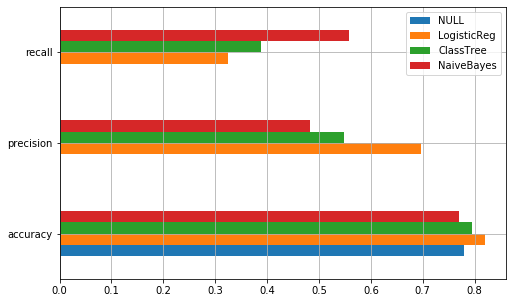

In [42]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.plot(kind='barh', ax=ax)
ax.grid();

In [43]:
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_true=y_test, 
                                                                probas_pred=NBC.predict_proba(X_test)[:,1])
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true=y_test, 
                                                                probas_pred=logistic_regression.predict_proba(X_test)[:,1])

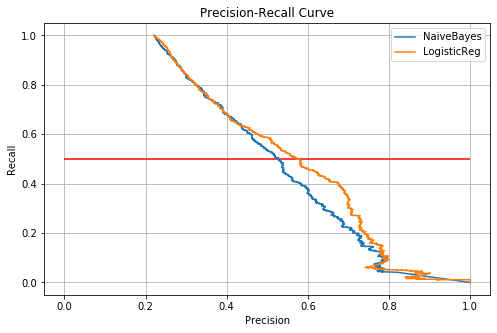

In [44]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(precision_nb, recall_nb, label='NaiveBayes')
ax.plot(precision_lr, recall_lr, label='LogisticReg')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.hlines(y=0.5, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid();

### Confusion matrix for modified Logistic Regression Classifier

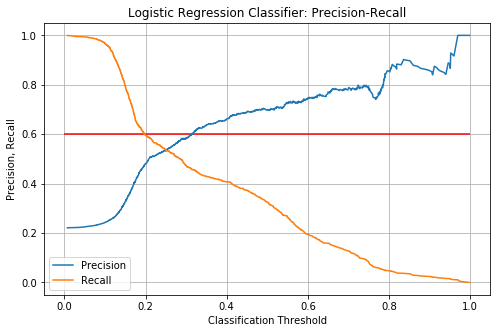

In [45]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(thresholds_lr, precision_lr[1:], label='Precision')
ax.plot(thresholds_lr, recall_lr[1:], label='Recall')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Precision, Recall')
ax.set_title('Logistic Regression Classifier: Precision-Recall')
ax.hlines(y=0.6, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid();